### IMPORTS

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier

## DATA LOADING

In [42]:
# Set pandas options to display all columns
pd.set_option('display.max_columns', None)

# Set pandas options to display all rows
pd.set_option('display.max_rows', None)

awards = pd.read_csv("../datasets/awards_players.csv")
coaches = pd.read_csv("../datasets/coaches.csv")
player_teams = pd.read_csv("../datasets/players_teams.csv")
players = pd.read_csv("../datasets/players.csv")
series_post = pd.read_csv("../datasets/series_post.csv")
teams_post = pd.read_csv("../datasets/teams_post.csv")
teams = pd.read_csv("../datasets/teams.csv")

dataframes = [awards, coaches, player_teams, players, series_post, teams_post, teams]
dataframe_names = ["awards", "coaches", "player_teams", "players", "series_post", "teams_post", "teams"]

As it was stated before, we decided to use the `teams.csv` dataset to start building the model. In order to accomplish that, we needed to check what features were available and what were the ones that should be removed due to lack of relevance or direct correlation with the target variable.

The features available in the `teams.csv` dataset are:

- `year` - The year the data was collected (important as the data for a certain year will be used to predict the next year's results);
- `lgID` - The league the team is part of (doesn't impact the model as all teams are from the same league);
- `tmID` - The team ID (important to identify the team and can be used to merge with other datasets);
- `franchID` - The franchise ID (basically the same as the team ID);
- `confID` - The conference ID (considering that four teams from each conference make the playoffs, this feature can be important);
- `divID` - The division ID (this feature will be removed as all rows are NaN);
- `rank` - The team's rank in the division;
- `playoff` - Whether the team made the playoffs or not;
- `seeded` - Whether the team was seeded or not;
- `firstRound`, `semis`, `final` - Whether the team made it to the first round, semis or finals of the playoffs;
- `name` - The team's name;
- `Team Stats` (will be important as the stats directly impact the team performance thus the playoff qualification):
    - `o_fgm` - Opponent field goals made;
    - `o_fga` - Opponent field goals attempted;
    - `o_ftm` - Opponent free throws made;
    - `o_fta` - Opponent free throws attempted;
    - `o_3pm` - Opponent three-pointers made;
    - `o_3pa` - Opponent three-pointers attempted;
    - `o_oreb` - Opponent offensive rebounds;
    - `o_dreb` - Opponent defensive rebounds;
    - `o_reb` - Opponent total rebounds;
    - `o_asts` - Opponent assists;
    - `o_pf` - Opponent personal fouls;
    - `o_stl` - Opponent steals;
    - `o_to` - Opponent turnovers;
    - `o_blk` - Opponent blocks;
    - `o_pts` - Opponent points;
    - `d_fgm` - Defensive field goals made;
    - `d_fga` - Defensive field goals attempted;
    - `d_ftm` - Defensive free throws made;
    - `d_fta` - Defensive free throws attempted;
    - `d_3pm` - Defensive three-pointers made;
    - `d_3pa` - Defensive three-pointers attempted;
    - `d_oreb` - Defensive offensive rebounds;
    - `d_dreb` - Defensive defensive rebounds;
    - `d_reb` - Defensive total rebounds;
    - `d_asts` - Defensive assists;
    - `d_pf` - Defensive personal fouls;
    - `d_stl` - Defensive steals;
    - `d_to` - Defensive turnovers;
    - `d_blk` - Defensive blocks;
    - `d_pts` - Defensive points;
    - `tmORB` - Team offensive rebounds (maintains value 0 for all rows, will be removed);
    - `tmDRB` - Team defensive rebounds (maintains value 0 for all rows, will be removed);
    - `tmTRB` - Team total rebounds (maintains value 0 for all rows, will be removed);
    - `opptmORB` - Opponent team offensive rebounds (maintains value 0 for all rows, will be removed);
    - `opptmDRB` - Opponent team defensive rebounds (maintains value 0 for all rows, will be removed);
    - `opptmTRB` - Opponent team total rebounds (maintains value 0 for all rows, will be removed);
    - `won` - Number of games won;
    - `lost` - Number of games lost;
    - `GP` - Games played;
    - `homeW` - Home wins;
    - `homeL` - Home losses;
    - `awayW` - Away wins;
    - `awayL` - Away losses;
    - `confW` - Conference wins;
    - `confL` - Conference losses;
    - `min` - Minutes played;
- `attend` - Attendance (probably not relevant for the model);
- `arena` - Arena name (categorical feature that will probably not be impactful for the model);

### INITIAL DATA CLEANING

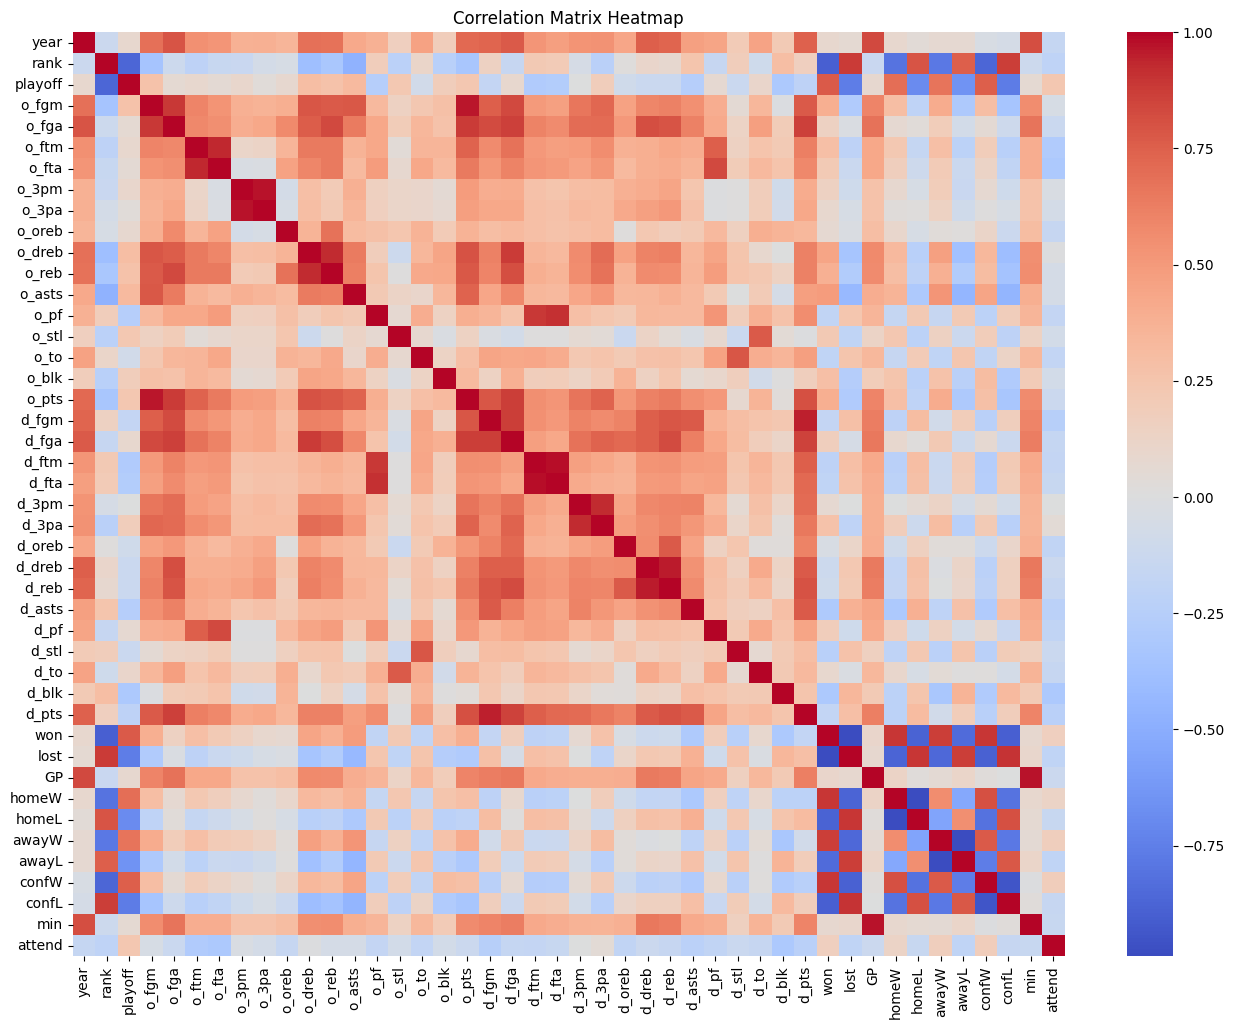

In [48]:
# Transform 'Y' to 1 and 'N' to 0 in the 'playoff' column
corr = teams.drop(['lgID', 'franchID', 'confID', 'divID', 'name', 'firstRound', 'semis', 'finals', 'arena', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB'], axis=1)
corr.sort_values(['tmID', 'year'])
corr['playoff'] = corr.groupby('tmID')['playoff'].shift(-1)
corr.loc[teams['tmID'] != corr['tmID'].shift(-1), "playoff"] = np.nan
corr = corr.drop('tmID', axis=1)
corr = corr.dropna()


corr.loc[teams['playoff'] == 'Y', 'playoff'] = 1
corr.loc[teams['playoff'] == 'N', 'playoff'] = 0
correlation_matrix = corr.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix Heatmap')
plt.show()


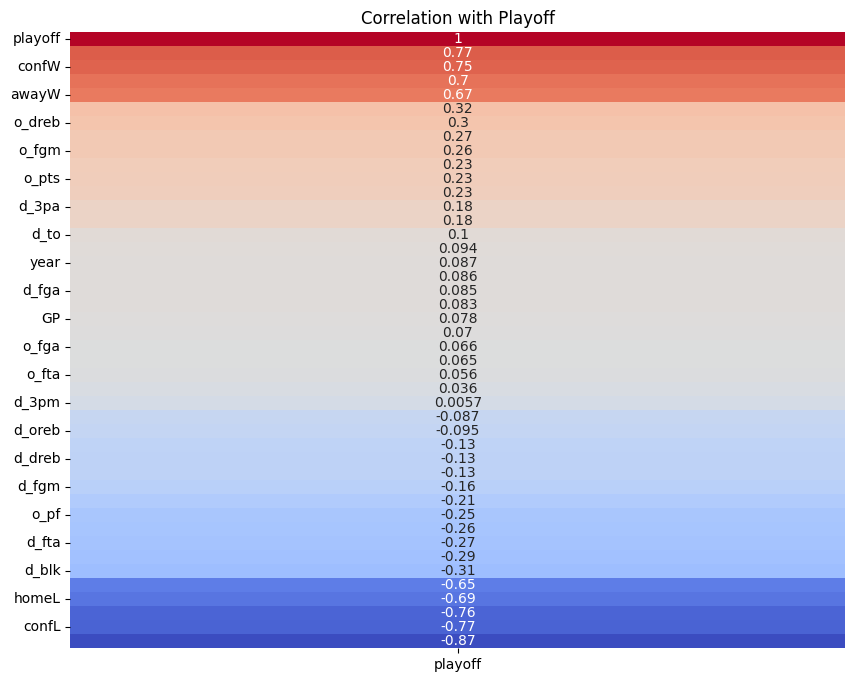

In [37]:
# Update correlation matrix
correlation_matrix = corr.corr()

# Extract correlations with the target variable 'playoff'
playoff_correlations = correlation_matrix['playoff'].sort_values(ascending=False)

# Visualize the top correlations with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(playoff_correlations.to_frame(), annot=True, cmap='coolwarm', cbar=False)
plt.title('Correlation with Playoff')
plt.show()

In [35]:

proc_data = teams.drop(['lgID', 'tmID', 'confID', 'divID', 'name', 'arena', 'finals', 'semis', 'firstRound'], axis=1)
proc_data.sort_values(['franchID', 'year'])
proc_data['playoff'] = proc_data.groupby('franchID')['playoff'].shift(-1)
proc_data.loc[proc_data['franchID'] != proc_data['franchID'].shift(-1), 'playoff'] = np.nan
proc_data = proc_data.drop('franchID', axis=1)

proc_data['playoff'] = proc_data['playoff'].map({'Y': 1, 'N': 0})

print(proc_data.head())

proc_data = proc_data.dropna()
testing_year = 8

x_train = proc_data.loc[proc_data['year'] <= testing_year].drop('playoff', axis=1)
y_train = proc_data.loc[proc_data['year'] <= testing_year]['playoff'].astype('int')

x_test = proc_data.loc[proc_data['year'] > testing_year].drop('playoff', axis=1)
y_test = proc_data.loc[proc_data['year'] > testing_year]['playoff'].astype('int')

   year  rank  playoff  seeded  o_fgm  o_fga  o_ftm  o_fta  o_3pm  o_3pa  \
0     9     7      1.0       0    895   2258    542    725    202    598   
1    10     2      NaN       0   1089   2428    569    755    114    374   
2     1     8      1.0       0    812   1903    431    577    131    386   
3     2     4      1.0       0    746   1780    410    528    153    428   
4     3     2      1.0       0    770   1790    490    663    211    527   

   o_oreb  o_dreb  o_reb  o_asts  o_pf  o_stl  o_to  o_blk  o_pts  d_fgm  \
0     340     737   1077     492   796    285   593    142   2534   1014   
1     404     855   1259     547   741    329   590    121   2861    996   
2     305     630    935     551   713    222   496     90   2186    879   
3     309     639    948     467   605    217   474    114   2055    732   
4     302     653    955     496   647    241   408    105   2241    778   

   d_fga  d_ftm  d_fta  d_3pm  d_3pa  d_oreb  d_dreb  d_reb  d_asts  d_pf  \
0   2254 

In [36]:
models = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Extra Trees', ExtraTreesClassifier()),
    ('MLP', MLPClassifier(random_state=184, max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC(random_state=42)),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Bernoulli Naive Bayes', BernoulliNB()),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

results = []

for model_name, model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append((model_name, accuracy))


print(accuracy_score(y_test, [1 for _ in y_test]))
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy'])
results_df = results_df.sort_values('Accuracy', ascending=False)
display(results_df)


0.6153846153846154


,Model,Accuracy
3,MLP,0.846154
0,Decision Tree,0.692308
8,Bernoulli Naive Bayes,0.615385
2,Extra Trees,0.615385
5,SVM,0.615385
9,Gradient Boosting,0.615385
1,Random Forest,0.538462
4,KNN,0.461538
7,Multinomial Naive Bayes,0.461538
6,Gaussian Naive Bayes,0.384615
